In [1]:
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image
from keras import backend as K
import numpy as np
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import cv2
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from tensorflow.keras.metrics import Precision, Recall
import random
import PIL
import pickle
from tensorflow.keras.optimizers.schedules import PolynomialDecay
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import statistics

In [2]:
tf.get_logger().setLevel('ERROR')
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [ ]:
input_dim = (92, 112)

def load_images(base_path):
    data = []
    labels = []

    person_images = {}

    if not os.path.isdir(base_path):
        person_name = base_path.split('\\')[-2]
        person_images[person_name] = [cv2.imread(base_path)]
        person_images[person_name] = [cv2.resize(img, input_dim) for img in person_images[person_name]]
        data.extend(person_images[person_name])
        labels.extend([person_name] * len(person_images[person_name]))

    else:
        for person_name in os.listdir(base_path):
            person_path = os.path.join(base_path, person_name)
            if os.path.isdir(person_path):
                if person_name not in person_images:
                    person_images[person_name] = []
                for img_name in os.listdir(person_path):
                    img_path = os.path.join(person_path, img_name)
                    img = cv2.imread(img_path)
                    img = cv2.resize(img, input_dim)
                    person_images[person_name].append(img)

        # Flatten the person_images dictionary into the data and labels lists
        for person_name, images in person_images.items():
            data.extend(images)
            labels.extend([person_name] * len(images))  # Use person_name as label

    return np.array(data), np.array(labels)


In [4]:
def generate_triplets(images, labels):
    triplets = []
    label_dict = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    for label in label_dict:
        for i in range(40):
            anchor_label = label
            positive_indices = label_dict[anchor_label]
            negative_label = random.choice([neg_label for neg_label in label_dict if neg_label != anchor_label])
    
            anchor_choice = random.choice(positive_indices)
            positive_choice = random.choice([pos_choice for pos_choice in positive_indices if pos_choice != anchor_choice])
            negative_choice = random.choice(label_dict[negative_label])
            anchor = images[anchor_choice]
            positive = images[positive_choice]
            negative = images[negative_choice]
    
            triplets.append((anchor, positive, negative))

    return triplets

In [5]:
dataset_path = './datasets'
train_path = os.path.join(dataset_path, "train")
val_path = os.path.join(dataset_path, "val")

if not os.path.isdir(os.path.join(".", "datasets")):
    dataset_url = "http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip"
    path_to_zip = tf.keras.utils.get_file('att_faces.tar.Z', origin=dataset_url, extract=True, cache_dir='.')
    dataset_dir = os.path.join(os.path.dirname(path_to_zip), 'olivetti')

    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)
    
    for identity in os.listdir(dataset_path):
        identity_path = os.path.join(dataset_path, identity)
        if not os.path.isdir(identity_path) or identity in ['train', 'val']:
            continue
    
        images = os.listdir(identity_path)
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
    
        train_identity_path = os.path.join(train_path, identity)
        val_identity_path = os.path.join(val_path, identity)
    
        os.makedirs(train_identity_path, exist_ok=True)
        os.makedirs(val_identity_path, exist_ok=True)
    
        for img in train_images:
            src = os.path.join(identity_path, img)
            dst = os.path.join(train_identity_path, img)
            shutil.move(src, dst)
    
        for img in val_images:
            src = os.path.join(identity_path, img)
            dst = os.path.join(val_identity_path, img)
            shutil.move(src, dst)
    
        shutil.rmtree(identity_path)

train_images, train_labels = load_images(train_path)
val_images, val_labels = load_images(val_path)
print(f"There are {len(train_images)} training images and {len(val_images)} validation images.")

There are 312 training images and 78 validation images.


In [6]:
l2_regularisation = 1e-3

def create_embedding_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    x = tf.image.rgb_to_grayscale(inputs)

    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same'
                      ,kernel_regularizer=tf.keras.regularizers.l2(l2_regularisation)
                     )(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same'
                      ,kernel_regularizer=tf.keras.regularizers.l2(l2_regularisation)
                     )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same'
                      ,kernel_regularizer=tf.keras.regularizers.l2(l2_regularisation)
                     )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(96, (5, 5), activation='relu', padding='same'
                      ,kernel_regularizer=tf.keras.regularizers.l2(l2_regularisation)
                     )(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)

    x = layers.Conv2D(128, (5, 5), activation='relu', padding='same'
                      ,kernel_regularizer=tf.keras.regularizers.l2(l2_regularisation)
                     )(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name="embedding_normalization")(x)

    return Model(inputs, x, name="EmbeddingModel")

def create_siamese_network(input_shape):
    embedding_model = create_embedding_model(input_shape)
    anchor_input = layers.Input(shape=input_shape, name="Anchor")
    positive_input = layers.Input(shape=input_shape, name="Positive")
    negative_input = layers.Input(shape=input_shape, name="Negative")

    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)

    outputs = layers.Concatenate(name="Embeddings")(
        [anchor_embedding, positive_embedding, negative_embedding]
    )

    return Model([anchor_input, positive_input, negative_input], outputs, name="SiameseNetwork")

In [7]:
def triplet_loss(margin=0.25):
    def loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return loss

In [8]:
def plot_triplets(anchors, positives, negatives, num_examples):
    plt.figure(figsize=(12, 4 * num_examples))
    for i in range(num_examples):
        # Display the anchor
        plt.subplot(num_examples, 3, i * 3 + 1)
        plt.imshow(cv2.cvtColor(anchors[i], cv2.COLOR_BGR2RGB))
        plt.title("Anchor")
        plt.axis("off")

        # Display the positive
        plt.subplot(num_examples, 3, i * 3 + 2)
        plt.imshow(cv2.cvtColor(positives[i], cv2.COLOR_BGR2RGB))
        plt.title("Positive")
        plt.axis("off")

        # Display the negative
        plt.subplot(num_examples, 3, i * 3 + 3)
        plt.imshow(cv2.cvtColor(negatives[i], cv2.COLOR_BGR2RGB))
        plt.title("Negative")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

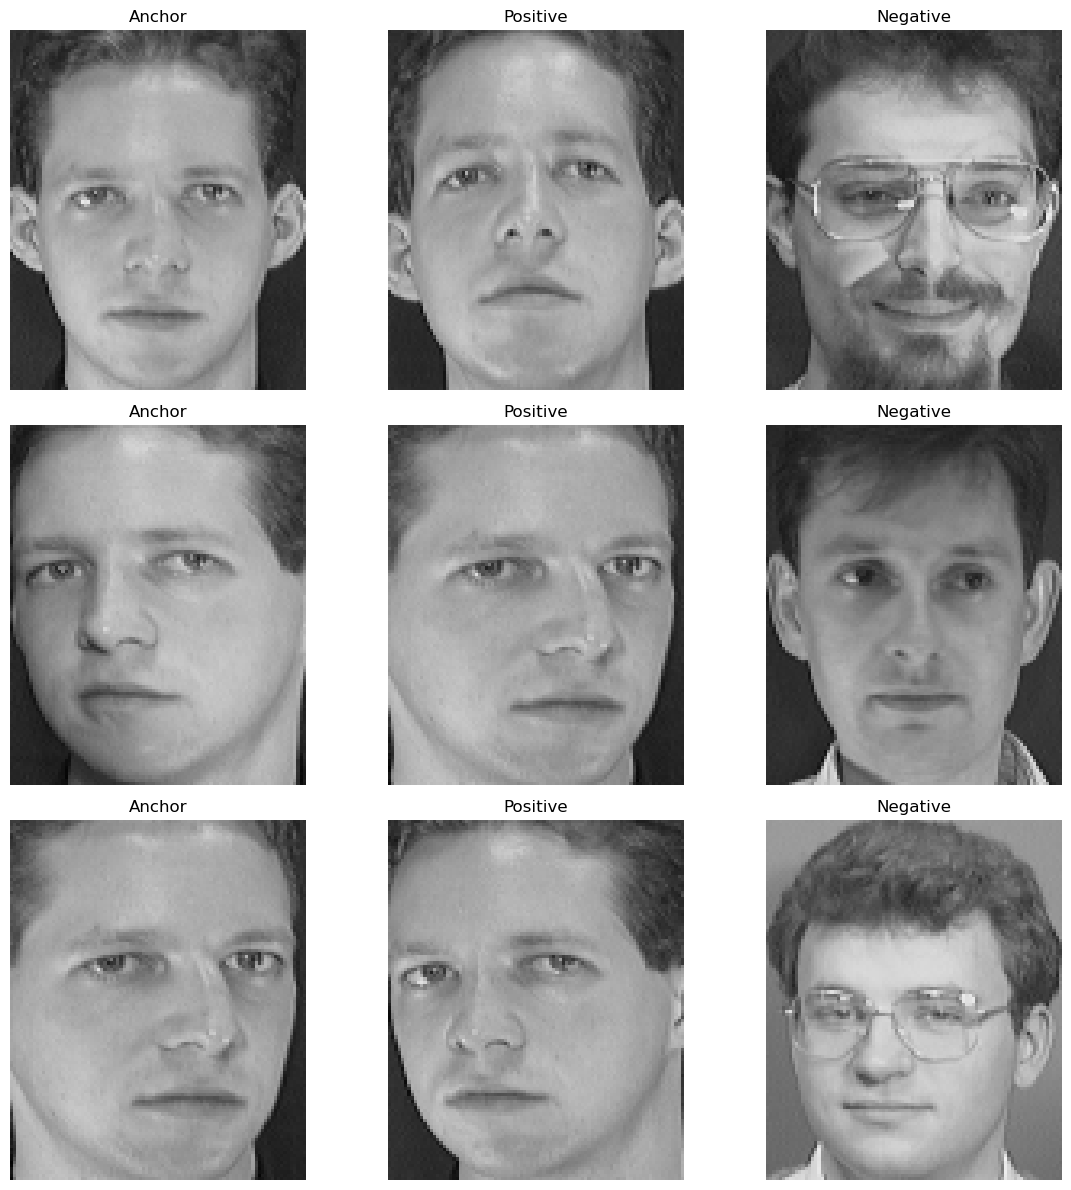

In [9]:
triplets = generate_triplets(train_images, train_labels)
anchors, positives, negatives = zip(*triplets)
anchors = np.array(anchors)
positives = np.array(positives)
negatives = np.array(negatives)
plot_triplets(anchors, positives, negatives, num_examples=3)

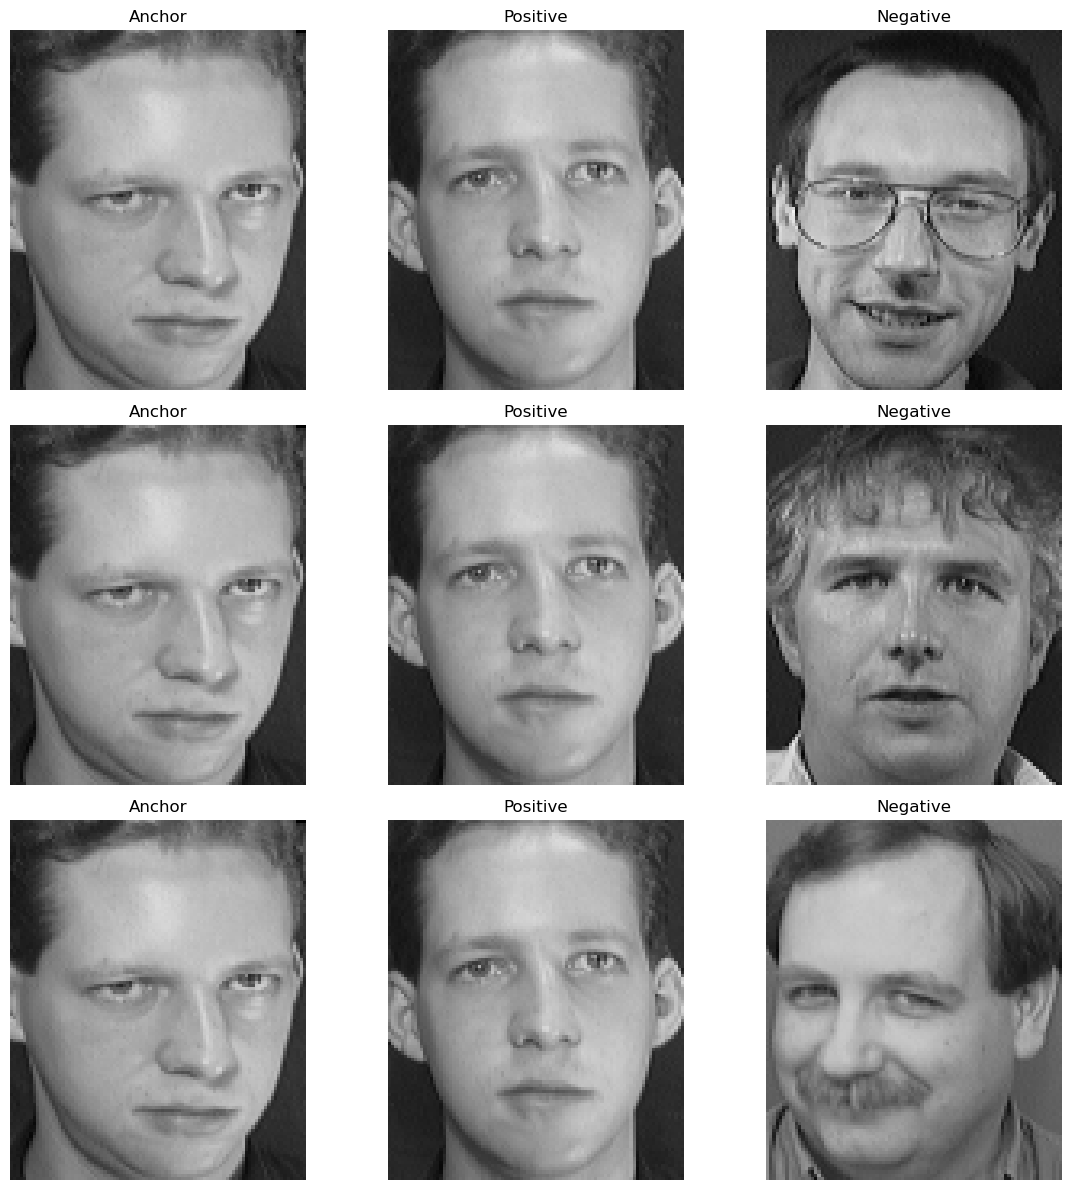

In [10]:
val_triplets = generate_triplets(val_images, val_labels)
val_anchors, val_positives, val_negatives = zip(*val_triplets)
val_anchors = np.array(val_anchors)
val_positives = np.array(val_positives)
val_negatives = np.array(val_negatives)
plot_triplets(val_anchors, val_positives, val_negatives, num_examples=3)

In [11]:
epoch = 5
batch_size = 16
lr_scheduler = PolynomialDecay(initial_learning_rate = 1e-3, end_learning_rate=0.0, decay_steps=(len(triplets)/batch_size))

input_shape = (112, 92, 3)
model = create_siamese_network(input_shape)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_scheduler),
    loss=triplet_loss()
)

model.fit(
    [anchors, positives, negatives],
    np.zeros(len(anchors)),
    epochs=epoch,
    batch_size=batch_size,
    validation_data=(
        [val_anchors, val_positives, val_negatives],
        np.zeros(len(val_anchors))
    ),
    shuffle=True
)

Epoch 1/5
98/98 [==============================] - 40s 388ms/step - loss: 0.2775 - val_loss: 0.2724
Epoch 2/5
98/98 [==============================] - 37s 378ms/step - loss: 0.2515 - val_loss: 0.2602
Epoch 3/5
98/98 [==============================] - 36s 369ms/step - loss: 0.2504 - val_loss: 0.2597
Epoch 4/5
98/98 [==============================] - 36s 367ms/step - loss: 0.2518 - val_loss: 0.2603
Epoch 5/5
98/98 [==============================] - 37s 372ms/step - loss: 0.2508 - val_loss: 0.2602


In [12]:
def save_embeddings(file_path, embeddings, labels):
    with open(file_path, 'wb') as f:
        pickle.dump({'embeddings': embeddings, 'labels': labels}, f)

In [48]:
embedding_model = create_embedding_model((112, 92, 3))  # Use the same architecture
embedding_model.build(input_shape=(None, 112, 92, 3))
embedding_model.set_weights(model.get_weights())  # Load trained weights

embedding_model.save_weights('embedding_model.h5')

val_embeddings = embedding_model.predict(val_images)

3/3 [==============================] - 0s 23ms/step


In [49]:
train_embeddings = embedding_model.predict(train_images)

with open("embeddings.pkl", "wb") as f:
    pickle.dump({"embeddings": train_embeddings, "labels": train_labels}, f)

val_embeddings_dict = {label: [] for label in np.unique(val_labels)}
for embedding, label in zip(val_embeddings, val_labels):
    val_embeddings_dict[label].append(embedding)

10/10 [==============================] - 0s 24ms/step


In [54]:
with open("embeddings.pkl", "rb") as f:
    train_data = pickle.load(f)

t_embeddings = train_data["embeddings"]
t_labels = train_data["labels"]

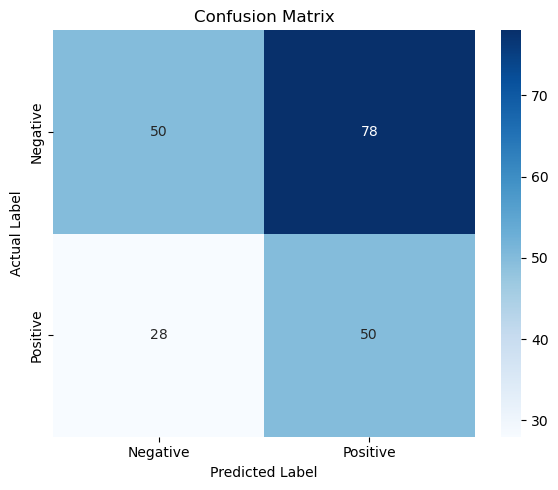

Threshold: 0.45, Accuracy: 98.24%, Recall: 64.10%, Precision: 39.06%, F1 Score: 0.4854


In [16]:
def test_recognition(embeddings, val_images, val_labels, threshold):
    correct = 0
    total = 0
    TP = 0
    FN = 0
    FP = 0
    TN = 0

    for i, emb1 in enumerate(embeddings):
        for j, emb2 in enumerate(embeddings):
            if i != j:
                dist = np.linalg.norm(emb1 - emb2)
                same_person = (val_labels[i] == val_labels[j])
                predicted_same = (dist < threshold)

                if same_person == predicted_same:
                    correct += 1
                total += 1

                if same_person == True:
                    if predicted_same == True:
                        TP += 1
                    else:
                        FN += 1

                else:
                    if predicted_same == True:
                        FP += 1
                    else:
                        TN += 1

    accuracy = correct / total
    recall = TP/(TP+FN)
    precision = TP/(TP+FP)
    f1score = (2*recall*precision)/(recall+precision)
    # conf_matrix = np.array([[TN, FP],
    #                     [FN, TP]])

    # labels = ["Negative", "Positive"]

    # plt.figure(figsize=(6, 5))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

    # plt.title("Confusion Matrix")
    # plt.ylabel("Actual Label")
    # plt.xlabel("Predicted Label")
    # plt.tight_layout()
    # plt.show()
    return accuracy, recall, precision, f1score, TP, FP, TP, FN
    
bestf1score = [0, 0, 0, 0, 0, 0, 0, 0]
for threshold in range(30, 801, 5):
    threshold = threshold/100
    accuracy, recall, precision, f1score, TP, FP, TP, FN = test_recognition(val_embeddings, val_images, val_labels, threshold)
    if f1score > bestf1score[4]:
        bestf1score = [threshold, accuracy, recall, precision, f1score, TP, FP, TP, FN]

conf_matrix = np.array([[bestf1score[7], bestf1score[6]],
                    [bestf1score[8], bestf1score[5]]])

labels = ["Negative", "Positive"]

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

print(f"Threshold: {bestf1score[0]}, Accuracy: {bestf1score[1] * 100:.2f}%, Recall: {bestf1score[2] * 100:.2f}%, Precision: {bestf1score[3] * 100:.2f}%, F1 Score: {bestf1score[4]:.4f}")
# accuracy, recall, precision, f1score = test_recognition(embedding_model, train_images, train_labels, 0.6)
# print(f"Accuracy: {accuracy * 100:.2f}%, Recall: {recall * 100:.2f}%, Precision: {precision * 100:.2f}%, F1 Score: {f1score}")

In [55]:
def recognize_face(test_embedding, stored_embeddings, stored_labels, threshold):
    distances = [np.linalg.norm(test_embedding - emb) for emb in stored_embeddings]
    # mean_distances = []

    # unique_labels = np.unique(stored_labels)
    
    # for label in unique_labels:
    #     indices = np.where(stored_labels == label)[0]  # Get all indices of this label
    #     if len(indices) == 0:
    #         continue
        
    #     mean_distance_for_person = statistics.mean([distances[i] for i in indices])
    #     mean_distances.append((label, mean_distance_for_person))

    # # Find best match using mean distances
    # best_label, min_mean_distance = min(mean_distances, key=lambda x: x[1])
    # if min_mean_distance > threshold:
    #     best_label = "unknown"

    # Find the closest individual embedding match
    min_distance = min(distances)
    best_match_idx = np.argmin(distances)
    closest_person = stored_labels[best_match_idx]
    if min_distance > threshold:
        closest_person = "unknown"

    # return best_label, min_mean_distance, mean_distances, distances, min_distance, closest_person
    return distances, min_distance, closest_person



In [56]:
# c1 = 0
# t1 = 0
c2 = 0
t2 = 0
for l in range(len(np.unique(t_labels))):
    person = os.listdir(val_path)[l]
    personpath = os.path.join(val_path, person)
    randomimage = os.listdir(personpath)[0]
    randomimagepath = os.path.join(personpath, randomimage)

    img1, label1 = load_images(randomimagepath)
    new_embedding = embedding_model.predict(img1)

    # mean_est_label, min_mean_distance, mean_distances, distances, min_distance, min_label = recognize_face(new_embedding, t_embeddings, t_labels, 0.4)
    distances, min_distance, min_label = recognize_face(new_embedding, t_embeddings, t_labels, 0.4)

    # if mean_est_label == person:
    #     c1 += 1
    # else:
    #     print(person)
    # t1 += 1

    if min_label == person:
        c2 += 1
    else:
        print(person)
    t2 += 1

# print(f"Accuracy: {c1}/{t1}, {c1/t1*100:.2f}%")
print(f"Accuracy: {c2}/{t2}, {c2/t2*100:.2f}%")

1/1 [==============================] - 0s 24ms/step
s16
1/1 [==============================] - 0s 25ms/step
s29
1/1 [==============================] - 0s 22ms/step
Accuracy: 37/39, 94.87%


In [76]:
def add_embedding(embedding_file, image_path, embedding_model=embedding_model):
    with open(embedding_file, "rb") as f:
        data = pickle.load(f)

    embeddings_list = data["embeddings"]
    labels_list = data["labels"]

    new_face_image = load_images(image_path)
    new_embedding = embedding_model.predict(new_face_image[0])
    new_identity = new_face_image[1][0]

    embeddings = np.append(embeddings_list, new_embedding, axis=0)
    labels = np.append(labels_list, new_identity)
    
    updated_data = {"embeddings": embeddings, "labels": labels}
    
    with open(embedding_file, "wb") as f:
        pickle.dump(updated_data, f)
    
    with open(embedding_file, "rb") as f:
        data = pickle.load(f)

    embeddings_list = list(data["embeddings"])
    labels_list = list(data["labels"])

    return embeddings, labels

In [86]:
t_embeddings, t_labels = add_embedding("embeddings.pkl", ".\\test_add_embedding\\train\\s40\\9.pgm")

1/1 [==============================] - 0s 20ms/step


In [90]:
img1, label1 = load_images(".\\10.jpeg")
new_embedding = embedding_model.predict(img1)

distances, min_distance, min_label = recognize_face(new_embedding, t_embeddings, t_labels, 0.4)
print(min_label)

1/1 [==============================] - 0s 23ms/step
s40
